# Actor-Critic
### Solving `Pendulum-v1` Problem
> Deep RL course - Fall 2024 - Sharif University of Technology - Workshop session <br>
> Author: M Narimani - December 15th, 2024 <br>

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
from tensorflow.keras import initializers

In [2]:
print("TensorFlow %s" % tf.__version__)
print("tfp %s" % tfp.__version__)
print("Keras %s" % keras.__version__)
print("gym %s" % gym.__version__)
print("numpy %s" % np.__version__)

TensorFlow 2.10.0
tfp 0.18.0
Keras 2.10.0
gym 0.26.0
numpy 1.23.0


In [3]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

Name: /physical_device:GPU:0   Type: GPU


## Extract features: RBFSampler

In [5]:
class FeatureTransformer:
    def __init__(self, env, n_components=100, n_samples=1000):
        observation_examples = np.array([env.observation_space.sample() for _ in range(n_samples)])
        scaler = StandardScaler()
        scaler.fit(observation_examples)

        featurizer = FeatureUnion([
            ("rbf1", RBFSampler(gamma=5.0, n_components=n_components)),
            ("rbf2", RBFSampler(gamma=2.0, n_components=n_components)),
            ("rbf3", RBFSampler(gamma=1.0, n_components=n_components)),
            ("rbf4", RBFSampler(gamma=0.5, n_components=n_components))
        ])
        example_features = featurizer.fit_transform(scaler.transform(observation_examples))

        self.dimensions = example_features.shape[1]
        self.scaler = scaler
        self.featurizer = featurizer

    def transform(self, observations):
        scaled = self.scaler.transform(observations)
        return self.featurizer.transform(scaled)

## Policy network

In [6]:
class PolicyModel(keras.Model):
    def __init__(self):
        super(PolicyModel, self).__init__()
        # initializer = #TODO: Add a kernel initializer for NN's initial weights
        self.mean_layer = keras.layers.Dense(1, activation='linear')
        self.stdv_layer = keras.layers.Dense(1, activation='softplus')

    def call(self, inputs):
        x = inputs
        mean = self.mean_layer(x)
        stdv = self.stdv_layer(x)
        return tf.squeeze(mean), tf.squeeze(stdv)

    def sample_action(self, state):
        mean, stdv = self(state)
        action = tf.random.normal(shape=mean.shape, mean=mean, stddev=stdv)
        return tf.clip_by_value(action, -2, 2)

## Value network (Baseline)

In [7]:
class ValueModel(keras.Model):
    def __init__(self):
        super(ValueModel, self).__init__()
        # initializer = #TODO: Add a kernel initializer for NN's initial weights
        self.output_layer = keras.layers.Dense(1, activation='linear')

    def call(self, inputs):
        x = inputs
        return tf.squeeze(self.output_layer(x))

## Actor-Critic algorithm

<center>
<img src="ac_dong.png" alt="Actor-Critic" width=500/>
</center>

In [8]:
def play_one_episode(env, ft, policy_model, value_model, gamma, max_steps):
    observation, _ = env.reset()
    done = False
    totalreward = 0
    iters = 0
    
    while not done and iters < max_steps:
        state = feature_transformer.transform(np.array([observation]))
        action = policy_model.sample_action(state)
        prev_observation = observation
        observation, reward, done, _, _ = env.step([action.numpy()])

        totalreward += reward

        next_state = feature_transformer.transform(np.array([observation]))
        V_next = value_model(next_state)
        G = reward + gamma * V_next
        advantage = G - value_model(state)

        with tf.GradientTape() as tape:
            mean, stdv = policy_model(state)
            dist = tfp.distributions.Normal(mean, stdv)
            log_prob = dist.log_prob(action)
            loss = -tf.reduce_sum(advantage * log_prob + 0.01 * dist.entropy()) # TODO: try without including the regularization term

        grads = tape.gradient(loss, policy_model.trainable_variables)
        policy_model.optimizer.apply_gradients(zip(grads, policy_model.trainable_variables))
        
        with tf.GradientTape() as tape:
            value_pred = value_model(state)
            value_loss = tf.reduce_sum(tf.square(G - value_pred))
        
        grads = tape.gradient(value_loss, value_model.trainable_variables)
        value_model.optimizer.apply_gradients(zip(grads, value_model.trainable_variables))

        iters += 1
    
    mse_v = float('nan') # TODO: calculate MSE for value network
    mae_pi = float('nan') # TODO: calculate MAE for policy network
    return totalreward, mse_v, mae_pi

In [9]:
def run_training(env, ft, num_episodes=150, lr_pi=1e-4, lr_val=1e-3, max_steps=200):
    policy_model = PolicyModel()
    value_model = ValueModel()
    discount_rate = 0.96
    
    episode_rewards = []
    episode_mse_v = []
    episode_mae_pi = []
    
    policy_model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_pi))
    value_model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_val))
    
    for n in range(num_episodes):
        total_reward, mse_v, mae_pi = play_one_episode(env, ft, policy_model, value_model, discount_rate, max_steps)
        episode_rewards.append(total_reward)
        episode_mse_v.append(mse_v)
        episode_mae_pi.append(mae_pi)
        if (n+1) % 10 == 0:
            print(f"Episode: {n+1:4d} | "
                  f"Score: {int(total_reward):5d} | "
                  f"Avg reward: {int(sum(episode_rewards)/len(episode_rewards)):5d} | "
                  f"Policy MAE: {mae_pi:.2f} | "
                  f"Value MSE: {mse_v:.2f}")

        # TODO: Add a convergence criteria

    episode_rewards = np.array(episode_rewards)
    episode_mse_v = np.array(episode_mse_v)
    episode_mae_pi = np.array(episode_mae_pi)
    
    return episode_rewards, episode_mse_v, episode_mae_pi, policy_model, value_model

## Main

In [10]:
%%time

num_episodes = 150
max_steps = 200
num_components = 100 # Number of RBFSampler components (multiply by 4): (determines the tunable weights for both NNs)
env = gym.make("Pendulum-v1")
feature_transformer = FeatureTransformer(env, n_components=num_components, n_samples=10000)

rewards, mae_v, mae_pi, policy_model, value_model = run_training(
    env,
    feature_transformer,
    num_episodes,
    lr_pi=1e-3,
    lr_val=1e-1,
    max_steps=max_steps)

Episode:   10 | Score: -1266 | Avg reward: -1065 | Policy MAE: 8.86 | Value MSE: 55.88
Episode:   20 | Score: -1193 | Avg reward: -1079 | Policy MAE: 6.67 | Value MSE: 27.23
Episode:   30 | Score:  -923 | Avg reward: -1044 | Policy MAE: 7.76 | Value MSE: 48.58
Episode:   40 | Score:  -122 | Avg reward:  -917 | Policy MAE: 1.06 | Value MSE: 8.64
Episode:   50 | Score:  -240 | Avg reward:  -795 | Policy MAE: 2.20 | Value MSE: 24.09
Episode:   60 | Score:  -125 | Avg reward:  -726 | Policy MAE: 1.55 | Value MSE: 19.20
Episode:   70 | Score:  -622 | Avg reward:  -676 | Policy MAE: 5.72 | Value MSE: 45.20
Episode:   80 | Score:  -129 | Avg reward:  -612 | Policy MAE: 2.00 | Value MSE: 10.00
Problem solved in 88 episodes.
CPU times: total: 6min 7s
Wall time: 11min 53s


# Results
## Learning curves

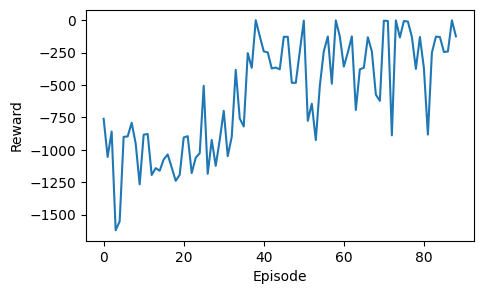

In [11]:
plt.figure(figsize=(5, 3))
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

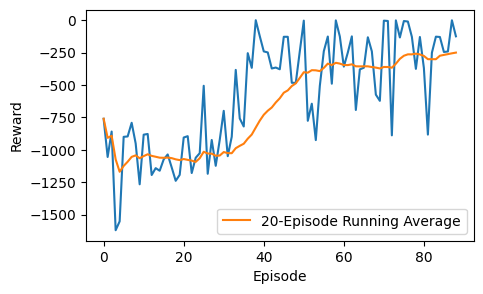

In [12]:
def plot_running_avg(rewards):
    N = len(rewards)
    rewards = np.array(rewards)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = rewards[max(0, t-20):(t+1)].mean()
    plt.figure(figsize=(5, 3))
    plt.plot(rewards)
    plt.plot(running_avg, label="20-Episode Running Average")
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.show()
    
plot_running_avg(rewards)

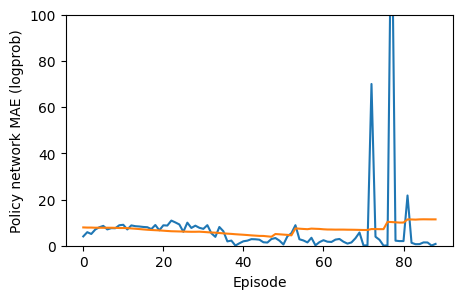

In [14]:
from scipy.ndimage import uniform_filter
mae_pi_avg = uniform_filter(mae_pi, size=50)

# MAEs
plt.figure(figsize=(5, 3))
plt.plot(mae_pi)
plt.plot(mae_pi_avg)
plt.xlabel('Episode')
plt.ylabel('Policy network MAE (logprob)')
plt.ylim(0, 100)
plt.show()

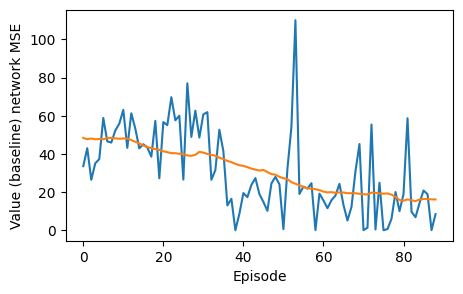

In [15]:
mae_v_avg = uniform_filter(mae_v, size=50)

plt.figure(figsize=(5, 3))
plt.plot(mae_v)
plt.plot(mae_v_avg)
plt.xlabel('Episode')
plt.ylabel('Value (baseline) network MSE')
# plt.ylim(-10, 10)
plt.show()

## Cost-to-go

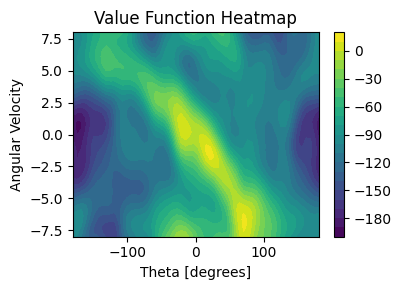

In [17]:
# TODO

## Policy map

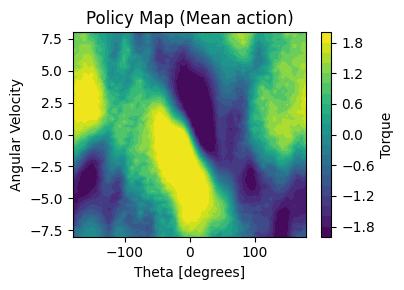

In [18]:
# TODO

## State histogram

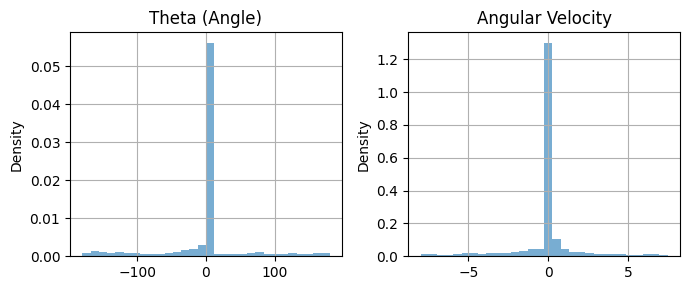

In [19]:
# TODO

## Render the learned policy
> You might want to install this lib first: `pip install opencv-python`

In [21]:
from IPython.display import Video, display
import cv2

def render_pendulum(ft, agent):
    env = gym.make('Pendulum-v1', render_mode='rgb_array')
    state, _ = env.reset()
    video_path = "AC_render.mp4"
    frame_width, frame_height = env.render().shape[1], env.render().shape[0]
    fourcc = cv2.VideoWriter_fourcc(*'avc1')
    out = cv2.VideoWriter(video_path, fourcc, 30, (frame_width, frame_height))
    for _ in range(max_steps):
        state = ft.transform(np.array([state]))
        action = agent.sample_action(state)
        state, _, done, _, _ = env.step([action.numpy()])
        frame = env.render()
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        out.write(frame_bgr)
    out.release()
    env.close()
    display(Video(video_path))

render_pendulum(feature_transformer, policy_model)